## Question 1

In [68]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt

%matplotlib inline

In [69]:
df = pd.read_csv("2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [70]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


Yup, the mean for order amount is $3145.

When we use .describe() on this data, we see that the standard deviation for order_amount is very high - 41,282. This means that the data points are quite spread out. This is demonstrated through the extremely high maximum value. You can see that while the 75th percentile value is only 390, the max value is 704,000! So, there are some outliers that cause the mean to be extremely high. Let's look at what could be causing these outliers.

### a. What is wrong with this calculation for AOV?

**Shop_id and Order_amount**

First, we'll look at how individual shops might be affecting AOV.

To get a better understanding of why the AOV might be so high, let's look at a scatter plot of the **shop_id vs order_amount**. We plot all points so that outliers are included.

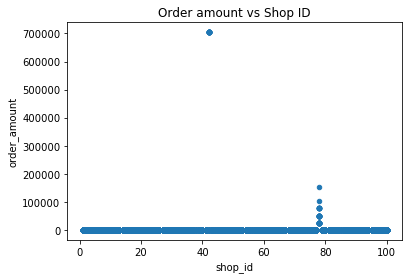

In [71]:
df.plot.scatter(x='shop_id',y='order_amount', title = 'Order amount vs Shop ID')

It looks like there are only two stores with high order amounts - 42 and 78. Let's look at the data from those stores.

In [83]:
df[(df.shop_id == 42) | (df.shop_id == 78)].sort_values(by=['shop_id', 'user_id', 'created_at']).head(10)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_shoe
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,352.0
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,352.0
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,352.0


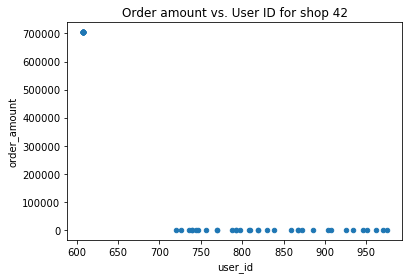

In [86]:
df[(df.shop_id == 42)].plot.scatter(x='user_id', y='order_amount', title='Order amount vs. User ID for shop 42')

It seems like a lot of the orders from store 42 (and from user 607) are all for the same amount and happen at the same time (4am), and with the same payment method (credit card). Interesting! We'll take a closer look at that later.  

The other orders from this shop are much lower and come from different users. 

In [84]:
df[(df.shop_id == 42) | (df.shop_id == 78)].sort_values(by=['shop_id', 'user_id', 'created_at']).tail(10)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_shoe
4079,4080,78,946,51450,2,cash,2017-03-20 21:14:00,25725.0
4311,4312,78,960,51450,2,debit,2017-03-01 3:02:10,25725.0
2690,2691,78,962,77175,3,debit,2017-03-22 7:33:25,25725.0
511,512,78,967,51450,2,cash,2017-03-09 7:23:14,25725.0
4420,4421,78,969,77175,3,debit,2017-03-09 15:21:35,25725.0
1204,1205,78,970,25725,1,credit_card,2017-03-17 22:32:21,25725.0
3440,3441,78,982,25725,1,debit,2017-03-19 19:02:54,25725.0
493,494,78,983,51450,2,cash,2017-03-16 21:39:35,25725.0
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57,25725.0
4584,4585,78,997,25725,1,cash,2017-03-25 21:48:44,25725.0


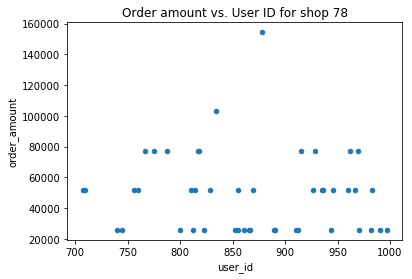

In [88]:
df[(df.shop_id == 78)].plot.scatter(x='user_id', y='order_amount', title='Order amount vs. User ID for shop 78')

These orders are **all** above 20,000 and come from a variety of users. Why does this shop have such high order amounts?

Maybe there's also a relationship between the order time and order value. Below, we plot created_at and order_amount.

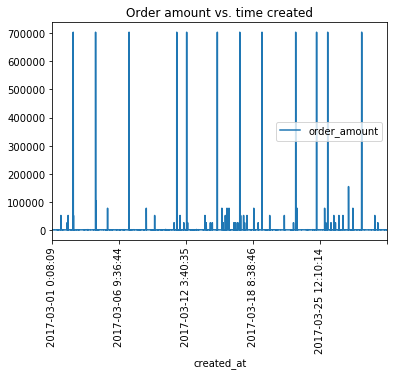

In [89]:
df.sort_values(by=['created_at']).plot(x='created_at', y='order_amount', rot=90, title = 'Order amount vs. time created')

It looks like there is an order for roughly 700,000 happening every few days. 

We can also look at the price per shoe for each store. 

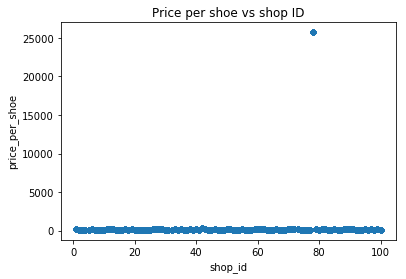

In [74]:
df['price_per_shoe'] = np.divide(df.order_amount,df.total_items)
df.plot.scatter(x='shop_id', y="price_per_shoe", title="Price per shoe vs shop ID")

Aha! There is one store (78) that sells **very** expensive shoes. This is why all the orders for this store were so high. Any orders from this store will cause a huge increase to AOV. 

So what have we learned from this section?
1. All of the high order values are coming from **2** of the 100 stores. 
2. One of these stores (42) has such high order values because one customer (607) regularly places orders of \$704,000.
3. The other store (78) has such high order values because the shoes are extremely expensive (\$25,725).

Now that we've examined the relationship between stores and order amount, let's take a look at users. 

**User_id and Order_amount**

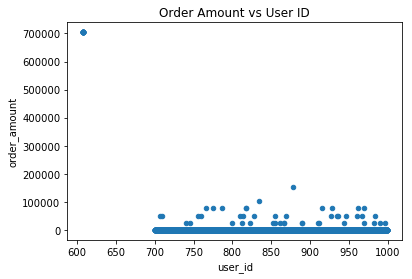

In [75]:
df.plot.scatter(x='user_id',y='order_amount', title='Order Amount vs User ID')

It seems like there is one user (607) who only has consistently high orders. The others tend to have lower values for order_amount except for a few outliers. 

Let's take another look at user 607.

In [76]:
df[df['user_id']==607].sort_values(by=['created_at'])

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_shoe
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,352.0
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,352.0
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,352.0


User 607 makes the **same order at the same time every few days**. It's likely that they are a business reselling shoes. 

Previously, we found that all of the high orders are happening at store 42 or store 78. We can infer that the high orders at store 42 are due to user 607 (a reseller). The other users with occasional high orders are all ordering expensive shoes from store 78.

Summary of findings:
1. One user (607) shops only from store 42, and makes the exact same order every few days. They use the same method of payment for each order (credit card) and place the order at exactly the same time. It's likely that this is a program set up for a reseller to automatically re-order the same shoes when supplies are low. 
2. The rest of the users who make expensive orders also place orders at other stores, but have made a a few at shop 42, where the shoes cost \$25,725. 

### How to better evaluate this data?

**1** - One better option for evaluating the data would be to take the **median order value**.

In [77]:
df['order_amount'].median()

284.0

Using the median order value removes the outlier problem, but it doesn't provide useful information about sales. For example, the it's possible for the median to be higher one month, but for sales to be lower.  For example, if month 1 has order amounts: (50,58,84,90,101), and month 2 has sales (23,44,88,89,95), the median has increased but total sales have decreased. 

**2** - Another option is to take the **truncated mean**. This means we ignore the top and bottom 10% of the data. Since we have 5000 orders, we'll ignore the highest and lowest 500 orders.

In [78]:
df_sorted = df.sort_values(by=['order_amount'])
df_sorted.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_shoe
158,159,92,795,90,1,credit_card,2017-03-29 3:07:12,90.0
3871,3872,92,818,90,1,debit,2017-03-18 9:10:08,90.0
4760,4761,92,937,90,1,debit,2017-03-20 7:37:28,90.0
4923,4924,92,965,90,1,credit_card,2017-03-09 5:05:11,90.0
4932,4933,92,823,90,1,credit_card,2017-03-24 2:17:13,90.0


In [79]:
df_truncated = df_sorted.iloc[499:4499]

In [80]:
df_truncated['order_amount'].mean()

287.29125

The truncated mean using the middle 80% is 287.29.

Again, this solution removes the problem of dealing with outliers. However, now we are missing a picture of the data. 

### b) What metric should we report?

I would choose to report the median order value over the truncated mean. I think it's more important to include all data, and the truncated mean completely removes any outliers. As mentioned previously, the drawback is that the median does not capture change in overall sales over time. However, it's important to note that this should not be the only metric used to evaluate the dataset. This should be analyzed in combination with other metrics to obtain a comprehensive picture of the data. 

### c) What is its value?

As mentioned previously, the median order value for this dataset is 284. 

## Question 2

a) **54 orders** were shipped by **Speedy Express**.

```
SELECT COUNT(OrderID) FROM [Orders] 
WHERE ShipperID = (
SELECT ShipperID 
FROM Shippers 
WHERE ShipperName = 'Speedy Express')
```

b) Last name is **Peacock** with **40 orders**

```
SELECT LastName, COUNT(*) FROM Employees 
INNER JOIN Orders ON Orders.EmployeeID = Employees.EmployeeID
GROUP BY Orders.EmployeeID
ORDER BY COUNT(*) DESC
LIMIT 1
```

c) **Boston Crab Meat** with **160 orders**

```
SELECT SUM(Quantity) as 'TotalOrders', ProductName FROM Products
INNER JOIN OrderDetails on Products.ProductID = OrderDetails.ProductID
INNER JOIN Orders on Orders.OrderID = OrderDetails.OrderID
INNER JOIN Customers on Customers.CustomerID = Orders.CustomerID
WHERE Customers.Country = 'Germany' 
GROUP BY Products.ProductName
ORDER BY SUM(QUANTITY) DESC
LIMIT 1
```

